# L-9-1: Inverse Classroom: It’s not working! Help!

These exercises will give you some debugging experience on problems typically found when doing machine learning in practice.

**Outline**

0. General Set-up
1. Debugging A Bad Training Set-up
2. Image Segmentation with DICE Loss
3. Fixing the Data-Processing Pipeline
4. Test Performance is Too Good!

## 0. General Set-up

Here we provide general code set-up: package requirements, train-loaders, etc.

In [1]:
## Some general imports we may need:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

Make sure GPU is enabled: In Colab, at the top, 

click `Runtime` -> `Change runtime type` -> `Hardware Accelerator` -> `GPU`

In [2]:
gpu_boole = torch.cuda.is_available()

In [3]:
## Basic dataloading for MNIST.
# Just to make sure it works for the rest of this notebook.
training = dataset.MNIST(root ='./data', transform=transforms.ToTensor(), train=True, download=True)
testing =  dataset.MNIST(root ='./data', transform = transforms.ToTensor(), train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing, batch_size = 128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.28MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.96MB/s]


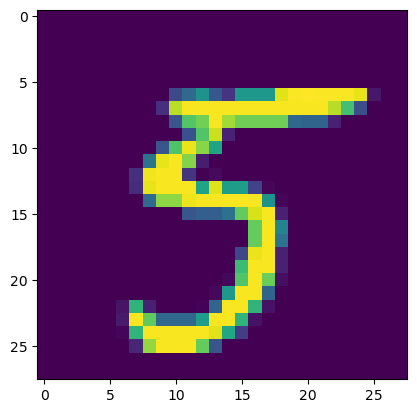

Label tensor(5)


In [4]:
## Plotting data to make sure it is correct:
x,y = next(iter(train_loader))
plt.imshow(x[0][0].cpu().data.numpy()) #plotting first channel of first image of MNIST
plt.show()
print('Label', y[0])

If you see an image of one of training samples above, then everything is working correctly for the next section.

**Some quick info about this dataset before starting:**
* We will be using the MNIST dataset, a handwritten digit dataset consisting of 10 classes, digits 0 through 9. MNIST consists of 60k training samples and 10k test samples. The images are of shape 28 x 28 (only one channel, grayscale).
* Typically MNIST is used as a baseline classification task for prototyping research ideas. In contemporary research, it is usually considered too easy for bonafide ideas to be validated on by itself, instead harder baselines are additionally provided. 
* For our purposes though, this dataset works well for this classroom setting and will provide us with some basic debugging experience.

## 1. Debugging A Bad Training Set-Up

* For this section, you are given a training loop for MNIST. 
* The loss curve doesn't look correct though, what is the issue?
* **Deliverables:** 
  * You will have to debug codeblocks below to achieve a good loss curve.
  * Explain what the problem or problems you found, what you ended up addressing, changing, or adding
  * Output a final test accuracy score of 90% or above in 2 epochs of training or less.

**Defining the model:**
Here we define a simple multi-layer perceptron (MLP) model, with two hidden layers and relu activations.

**NOTE: Although you are free to play around with the Net model definition, it's not needed to "solve" this notebook.**

In [5]:
class Net(nn.Module):
  def __init__(self, input_size, width, num_classes):
    super(Net, self).__init__()

    ##feedfoward layers:
    self.ff1 = nn.Linear(input_size, width) #input

    self.ff2 = nn.Linear(width, width) #hidden layers
    self.ff3 = nn.Linear(width, width)

    self.ff_out = nn.Linear(width, num_classes) #logit layer     

    ##activations:
    self.relu = nn.ReLU()

    #other activations:
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

    ## Some normalization functions.
    ## Feel free to add them into the forward pass if you like.
    
    #dropout:
    self.do = nn.Dropout()

    #batch-normalization:
    self.bn1 = nn.BatchNorm1d(width)
    self.bn2 = nn.BatchNorm1d(width)
    self.bn3 = nn.BatchNorm1d(width)

                
  def forward(self, input_data):
    out = self.relu(self.ff1(input_data)) 
    out = self.relu(self.ff2(out)) 
    out = self.relu(self.ff3(out))
    out = self.ff_out(out)
    return out #returns class probabilities for each image


**Instantiating the model:** we instantiate the model with a width of 500 and 10 classes.

In [6]:
net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
  net = net.cuda()

**Defining the optimizer:** we set the optimization procedure as stochastic gradient descent with various parameters. We also define our loss function.

In [7]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.9, momentum = 0.9, weight_decay = 0.0000001, dampening = 0.000002, nesterov = False)
loss_metric = nn.CrossEntropyLoss()

**Defining dataset loaders:** here, we define the dataset loaders with a specific batch size of 128 and basic tensor transformation / preprocessing:



In [8]:
training = dataset.MNIST(root ='./data', transform=transforms.ToTensor(), train=True, download=True)
testing =  dataset.MNIST(root ='./data', transform = transforms.ToTensor(), train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing, batch_size = 128, shuffle=False)

**Defining training and test loss and accuracy functions:** These functions will be useful in our training loop to view are training and test loss/accuracy at each epoch.

In [9]:
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)
        
    if verbose:
        print('Train accuracy: %f %%' % (100 * correct / total))
        print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)

    if verbose:
        print('Test accuracy: %f %%' % (100 * correct / total))
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total


**Traning loop:** here, we give the training loop. A number of epochs is set. Loss is recorded and plotted at the end.

**IMPORTANT NOTE:** For re-running this code cell, if you encounter nan loss, you will need to reinstantiate your model and optimizer by re-running the "Instantiating the model:" and "Defining the optimizer:" code cells above.

Starting Training
Epoch 1 :
Train accuracy: 11.236667 %
Train loss: 0.018056
Test accuracy: 11.350000 %
Test loss: 0.018257
Elapsed time for epoch: 43.26759696006775 s
ETA of completion: 0.7211266160011292 minutes

Epoch 2 :
Train accuracy: 9.736667 %
Train loss: 0.018089
Test accuracy: 9.820000 %
Test loss: 0.018287
Elapsed time for epoch: 42.27096152305603 s
ETA of completion: 0.0 minutes



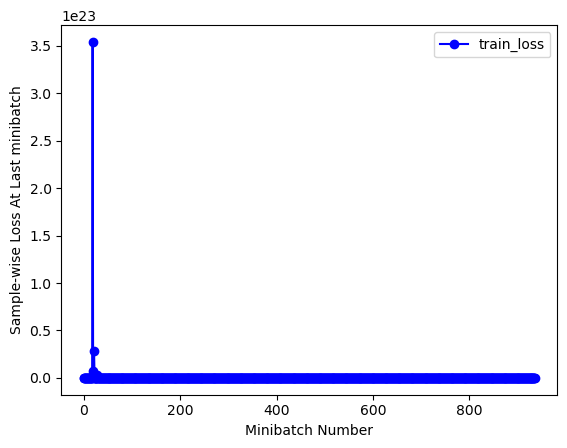

In [10]:
#re-initializing network weights:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)

weights_init(net)

#number of epochs to train for:
epochs = 2

#defining batch train loss recording arrays for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
  time1 = time.time() #timekeeping

  for i, (x,y) in enumerate(train_loader):

    #reshaping to flat shape:
    x = x.view(-1,28*28)

    if gpu_boole:
      x = x.cuda()
      y = y.cuda()

    #loss calculation and gradient update:

    if i > 0 or epoch > 0:
      optimizer.zero_grad()
    outputs = net.forward(x)
    loss = loss_metric(outputs,y)
    loss.backward()

    if i > 0 or epoch > 0:
      loss_batch_store.append(loss.cpu().data.numpy().item())
                  
    ##performing update:
    optimizer.step()

  print("Epoch",epoch+1,':')
  train_perc, train_loss = train_eval()
  test_perc, test_loss = test_eval()

  time2 = time.time() #timekeeping
  print('Elapsed time for epoch:',time2 - time1,'s')
  print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
  print()

## Plotting batch-wise train loss curve:
plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Minibatch Number')
plt.ylabel('Sample-wise Loss At Last minibatch')
plt.legend()
plt.show()


**What went wrong?**

* The loss curve doesn't look right (no clear, gradual decrease in train loss over time), and your train and test accuracy are terrible and stuck at around random chance. Worse yet, your loss is returning nan ("not a number")!

* Go through the codeblocks above to try and debug the problem. Is optimization procedure correcly specified? Are hyperparameters reasonable? Should batch-size be increased or decreased? Should initialization be done differently?

* Your job will be to make adjustments, figure out any problems that may be occurring, and make the output give a test accuracy of 90% or above (for 2 epochs of training or less).

**Explain your changes, additions, and adjustments below. Describe what led to a better training procedure and why:**

[Your text here]